<b> Part 1: Getting Started </b><br>

First, we wrote starter code to output the information extracted from BGP updates. We extracted a stream of updates using pybgpstream and filtered for specific time period, record types and collectors to narrow the stream. Each time a valid update from an AS is read, we print the update with all its fields, which includes the AS path of the update. 

In [43]:
import pybgpstream

# Create a new BPPStream instance for a 1 second window of time 
one_sec_stream = pybgpstream.BGPStream(
   from_time="2017-07-07 00:00:00", until_time ="2017-07-07 00:00:01 UTC",
   collectors=["route-views.sg", "route-views.eqix"],
   record_type="updates"
)

# Print BGP updates from stream 
for elem in one_sec_stream:
    print(elem)
    

update|A|1499385600.000000|routeviews|route-views.eqix|None|None|6939|206.126.236.37|91.192.240.0/22|206.126.236.37|6939 29632 31560||None|None
update|A|1499385600.000000|routeviews|route-views.eqix|None|None|11039|206.126.236.172|91.192.240.0/22|206.126.236.172|11039 6461 1299 29632 31560|6461:5997|None|None
update|A|1499385600.000000|routeviews|route-views.eqix|None|None|11039|206.126.236.172|91.192.240.0/22|206.126.236.172|11039 4901 11164 6939 12389 29076 197498 29632 31560||None|None
update|A|1499385600.000000|routeviews|route-views.eqix|None|None|11039|2001:504:0:2:0:1:1039:1|2804:2478::/32|2001:504:0:2::6939:1|11039 6939 53180 264224||None|None
update|W|1499385600.000000|routeviews|route-views.eqix|None|None|11039|206.126.236.172|186.250.114.0/24|None|None|None|None|None
update|A|1499385600.000000|routeviews|route-views.sg|None|None|38880|2001:de8:4::3:8880:1|2804:14c:da86::/48|2001:de8:4::6939:1|38880 6939 3356 4230 28573||None|None
update|A|1499385600.000000|routeviews|route-v

<b> Part 2: Training Our Code </b><br> 

In order to detect BGP Hijacks, we need to establish the true origins of prefixes. We do this by training our code on updates from BGPStream to build a global view of the network. We use the NetworkX package to generate as_graph,  a simple undirected graph of the network of ASes with no loops or self-edges. We also use adr_dct, a dictionary of dictionaries to maintain prefixes and keep track of their true origins. 

In [61]:
START_TIME = "2017-06-30 01:00:00"
END_TIME = "2017-07-07 01:00:00 UTC"

# Get data
stream = pybgpstream.BGPStream(
   from_time=START_TIME, until_time=END_TIME,
   collectors=["route-views.sg", "route-views.eqix"],
   record_type="updates"
)
stream.set_data_interface_option("broker", "cache-dir", "/home/mgumilang/.cache/")

In [62]:
# "Train" the code by building the global view of the network
import networkx as nx
import operator
from itertools import groupby
from collections import Counter

# init graph
as_graph = nx.Graph()

# init prefix dictionary
adr_dict = {}

for rec in stream.records():
    for elem in rec:
        # If element type == W, then remove the AS that announced it
        # else add AS path to graph
        if elem.type == 'W':
            pass
            # # Get origin adress to get the ASN
            # pfx = elem.fields['prefix']
            # origin_adr,mask = pfx.split('/')
            # # Remove if ASN in dictionary, else ignore
            # if origin_adr in adr_dict:
            #     asn = adr_dict[origin_adr]['asn']
            #     if asn != -1:
            #         as_graph.remove_node(asn)
        else:
            # Get the peer ASn and address
            peer = str(elem.peer_asn)
            peer_adr = str(elem.peer_address)
            # Get the array of ASns in the AS path and remove repeatedly prepended ASns
            hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]

            if len(hops) > 1 and hops[0] == peer:
                # Get the origin ASn and its prefix
                origin = hops[-1]
                pfx = elem.fields['prefix']
                # Add new edges to the NetworkX graph
                for i in range(0,len(hops)-1):
                    as_graph.add_edge(hops[i],hops[i+1])
                
                # Update prefix dictionary
                ## From peer
                if peer_adr not in adr_dict:
                    adr_dict[peer_adr] = {'counter': Counter(), 'mask': 99, 'asn': -1}
                adr_dict[peer_adr]['counter'].update([peer])

                # adr_dict[peer_adr]['asn'] = max(adr_dict[peer_adr]['counter'].items(), key=operator.itemgetter(1))[0]

                ## From origin
                origin_adr,mask = pfx.split('/')
                if origin_adr not in adr_dict:
                    adr_dict[origin_adr] = {'counter': Counter(), 'mask': 99, 'asn': -1}
                adr_dict[origin_adr]['mask'] = min(adr_dict[origin_adr]['mask'], int(mask))
                adr_dict[origin_adr]['counter'].update([origin])

                # adr_dict[origin_adr]['asn'] = max(adr_dict[origin_adr]['counter'].items(), key=operator.itemgetter(1))[0]

                # Update prefix to origin node
                # as_graph.nodes[origin]['prefix'].update([pfx])

# Update true asn for each prefix in dictionary
# Max count in 'counter' = true asn
for k in adr_dict:
    adr_dict[k]['asn'] = max(adr_dict[k]['counter'].items(), key=operator.itemgetter(1))[0]

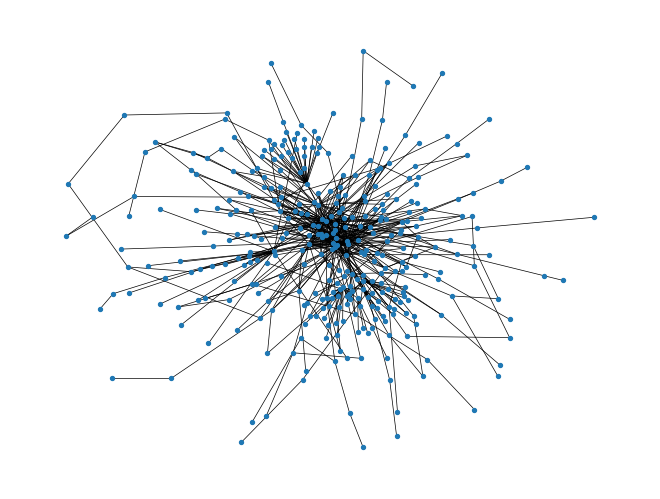

In [7]:
# Draw initial graph
nx.draw(as_graph, width=0.5, node_size=8)

In [46]:
# Implement MoAS detector
def is_moas(adr_dict, pfx, asn):
    # Check if address is truly belong to the asn
    # adr_dict: dictionary of address and the asn they belong too
    # pfx: string of address/mask ('111.111.111.111/22')
    # asn: int (the origin or the last hop in AS path)
    adr,_ = pfx.split('/')
    return adr_dict[adr]['asn'] != asn

In [47]:
# Implement sub-MoAS detector

def is_sub_moas(adr_dict, pfx, asn):
    # MoAS + if mask of prefix is bigger (more specific)
    # adr_dict: dictionary of address and the asn they belong too
    # pfx: string of address/mask ('111.111.111.111/22')
    # asn: int (the origin or the last hop in AS path)
    adr,mask = pfx.split('/')
    if adr_dict[adr]['asn'] != asn:
        if int(mask) > adr_dict[adr]['mask']:
            return True
    return False

In [48]:
# Implement Fake Path detector
def is_fake_path(G, as_path):
    # G: AS graph
    # as path: list of int
    # list of asn nodes that are potentially in graph
    # return true if as_path is in graph, false otherwis
    for i in range(len(as_path)-1):
        if not G.has_edge(as_path[i],as_path[i+1]):
            return True
    return False

In [49]:
# Implement DEFCON #16
def is_defcon(G, adr_dict, pfx, as_path):
    # Check if the as_path is correct but the prefix announced is fake and more specific
    # G: AS graph
    # as path: list of int
    # adr_dict: dictionary of address and the asn they belong too
    # pfx: string of address/mask ('111.111.111.111/22')
    origin = as_path[-1]
    adr,mask = pfx.split('/')
    if (not is_fake_path(G, as_path)) and (origin == adr_dict[adr]['asn']):
        if int(mask) > adr_dict[adr]['mask']:
            return True
    return False

In [63]:
# Detect hijacks for the next 30-minute stream
import time

# Get data
START_TIME = "2017-07-07 01:00:00"
END_TIME = "2017-07-07 01:30:00 UTC"

stream = pybgpstream.BGPStream(
   from_time=START_TIME, until_time=END_TIME,
   collectors=["route-views.sg", "route-views.eqix"],
   record_type="updates"
)
stream.set_data_interface_option("broker", "cache-dir", "/home/mgumilang/.cache/")

# init dictionary to log time for each hijack (in seconds)
# first-hijack: time to detect the first hijack after running the stream
# log: list of time to take to detect for each element
time_dict = {'moas': {'first-hijack': 0, 'log': []},
             'sub-moas': {'first-hijack': 0, 'log': []},
             'fake-path': {'first-hijack': 0, 'log': []},
             'defcon': {'first-hijack': 0, 'log': []}}

start_stream = time.time()
for rec in stream.records():
   for elem in rec:
      start_elem = time.time()
      # Ignore type 'W' record
      if elem.type == 'W':
         continue
      # Get data from announcement
      peer = str(elem.peer_asn)
      peer_adr = str(elem.peer_address)
      # Get the array of ASns in the AS path and remove repeatedly prepended ASns
      hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]
      
      # Ignore prefixes that are not in dictionary
      pfx = elem.fields['prefix']
      adr,mask = pfx.split('/')
      if adr not in adr_dict:
         continue

      if hops[0] == peer:
         # Get the origin ASn and its prefix
         origin = hops[-1]

         # Check for MoAS
         if is_moas(adr_dict, pfx, origin):
            time_detect = time.time()
            if time_dict['moas']['first-hijack'] == 0:
               time_dict['moas']['first-hijack'] = time_detect - start_stream
            time_dict['moas']['log'].append((time_detect - start_elem) * (10**3))
            print("Found MoAS ({}): True origin = {}, Hijacker = {}".format(pfx, adr_dict[adr]['asn'], origin))
         
         # Check for Sub-MoAS
         if is_sub_moas(adr_dict, pfx, origin):
            time_detect = time.time()
            if time_dict['sub-moas']['first-hijack'] == 0:
               time_dict['sub-moas']['first-hijack'] = time_detect - start_stream
            time_dict['sub-moas']['log'].append((time_detect - start_elem) * (10**3))
            print("Found Sub-MoAS ({}): True origin = {} with mask = {}, Hijacker = {} with mask = {}".format(
               pfx, adr_dict[adr]['asn'], adr_dict[adr]['mask'], origin, mask))
            
         # Check for Fake AS Path
         if is_fake_path(as_graph, hops):
            time_detect = time.time()
            if time_dict['fake-path']['first-hijack'] == 0:
               time_dict['fake-path']['first-hijack'] = time_detect - start_stream
            time_dict['fake-path']['log'].append((time_detect - start_elem) * (10**3))
            print("Found Fake AS Path: {}, Hijacker = {}".format(hops, origin))

         # Check for DEFCON #16
         if is_defcon(as_graph, adr_dict, pfx, hops):
            time_detect = time.time()
            if time_dict['defcon']['first-hijack'] == 0:
               time_dict['defcon']['first-hijack'] = time_detect - start_stream
            time_dict['defcon']['log'].append((time_detect - start_elem) * (10**3))
            print("Found DEFCON #16({}): True mask = {}, False mask = {}, Hijacker = {}".format(
               pfx, adr_dict[adr]['mask'], mask, origin))

Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(103.230.50.0/24): True mask = 23, False mask = 24, Hijacker = 133456
Found DEFCON #16(203.23.78.0/24): True mask = 23, False mask = 24, Hijacker = 10223
Found DEFCON #16(220.157.64.0/22): True mask = 19, False mask = 22, Hijacker = 9723
Found DEFCON #16(202.183.108.0/24): True mask = 23, False mask =

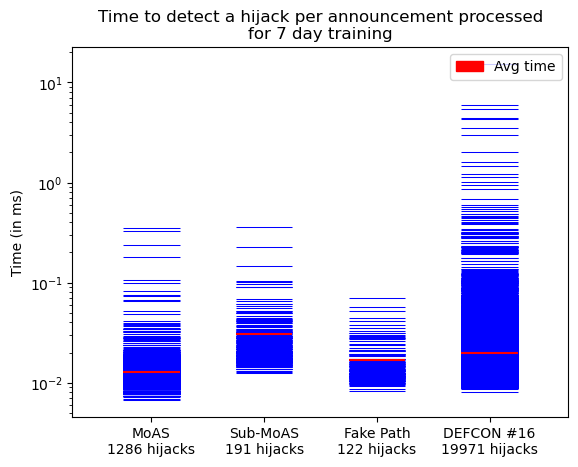

In [64]:
# Process time data and create graph
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

data = []

for k in time_dict:
    time_log = time_dict[k]['log']
    time_dict[k]['avg'] = sum(time_log)/len(time_log)
    data.append(np.array(time_log))
    data.append([time_dict[k]['avg']])

fig, ax = plt.subplots()

# Draw graph
offsets = [2, 2, 4, 4, 6, 6, 8, 8]
colors = ['b', 'r'] * 4
widths = [0.75, 1.5] * 4
ax.eventplot(data, orientation='vertical', 
             lineoffsets=offsets, linewidths=widths,
             colors=colors)
ax.set_xticks([2, 4, 6, 8])
ax.set_xticklabels(["MoAS\n{} hijacks".format(len(time_dict['moas']['log'])), 
                    "Sub-MoAS\n{} hijacks".format(len(time_dict['sub-moas']['log'])), 
                    "Fake Path\n{} hijacks".format(len(time_dict['fake-path']['log'])), 
                    "DEFCON #16\n{} hijacks".format(len(time_dict['defcon']['log']))])
red_patch = mpatches.Patch(color='red', label='Avg time')
ax.legend(handles=[red_patch])
ax.set_yscale('log')
ax.set_ylabel("Time (in ms)")
ax.set_title("Time to detect a hijack per announcement processed\nfor 7 day training")
plt.show()

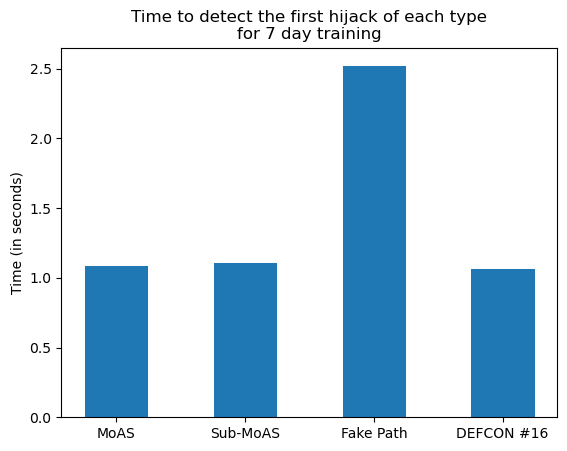

In [65]:
fig, ax = plt.subplots()

x = [2,4,6,8]
y = [time_dict[k]['first-hijack'] for k in time_dict]
ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set_xticks([2, 4, 6, 8])
ax.set_xticklabels(["MoAS", "Sub-MoAS", "Fake Path", "DEFCON #16"])

ax.set_ylabel("Time (in seconds)")
ax.set_title("Time to detect the first hijack of each type\nfor 7 day training")

plt.show()